# Fiber Network

In [1]:
%matplotlib inline
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from ufl import diag, Jacobian, shape
import os
os.chdir('../..') # change directory to main module directory
from arc_length.displacement_control_solver import displacement_control # import displacement control formulation of arc-length solver


parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 4
parameters['reorder_dofs_serial'] = False

ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# Import Mesh and define function spaces
In the case of 2D beams we also define the rotation matrix about the $z$ axis and directional derivative with respect to the beam centerline.

In [2]:
mesh = Mesh()
with XDMFFile(os.getcwd()+'/examples/displacement_control/voronoi.xdmf') as infile:
    infile.read(mesh)
    

Ue = VectorElement("CG", mesh.ufl_cell(), 2, dim=2) # displacement
Te = FiniteElement("CG", mesh.ufl_cell(), 1) # rotation
V = FunctionSpace(mesh, MixedElement([Ue, Te]))   

v_ = TestFunction(V)
u_, theta_ = split(v_)
dv = TrialFunction(V)
v = Function(V, name="Generalized displacement")
u, theta = split(v)

VR = TensorFunctionSpace(mesh, "DG", 0, shape=(2, 2))
R_old = Function(VR, name="Previous rotation matrix")
R_old.interpolate(Constant(((1, 0), (0, 1))))

V0 = FunctionSpace(mesh, "DG", 0)
curv_old = Function(V0, name="Previous curvature strain")


Vu = V.sub(0).collapse()
disp = Function(Vu)

Jac = Jacobian(mesh)
gdim = mesh.geometry().dim()
Jac = as_vector([Jac[i, 0] for i in range(gdim)])
g01 = Jac/sqrt(dot(Jac, Jac))
g02 = as_vector([-g01[1],g01[0]])

r01 = outer(g01,as_vector([1,0]))
r02 = outer(g02, as_vector([0,1]))

R0 = r01+r02

#-----------------------Define Functions for beams-----------------------------------#
def tgrad(u): # directional derivative w.r.t. beam centerline
    return dot(grad(u), g01)

def rotation_matrix(theta): # 2D rotation matrix -- there is no need to do rotation parametrization for 2D beams
    return as_tensor([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
Rot = rotation_matrix(theta)

# Define Dirichlet Boundary Conditions

In [3]:
H = 100.0
w = 100.0

def bottom(x, on_boundary):
    return near(x[1], 0, 1e-6) 
def top(x, on_boundary):
    return near(x[1], H,1e-6) 

def left(x, on_boundary):
    return near(x[0], 0,1e-6)
def right(x, on_boundary):
    return near(x[0], w,1e-6)


BC_bot = DirichletBC(V, Constant((0.0,0.0,0.0)), bottom) # fixed displacement and rotation
BC_top_x = DirichletBC(V.sub(0).sub(0), Constant(0.0), top) # fix displacement
BC_top_rot = DirichletBC(V.sub(1), Constant(0.0), top) # fix rotation

apply_disp = Expression("-t", t=0.0, degree = 0) # Create expression to compress the top
BC_top_y = DirichletBC(V.sub(0).sub(1),apply_disp,top) # incrementally compress the top 

bcs = [BC_bot, BC_top_y, BC_top_rot, BC_top_x]

# Kinematics and Weak Form

In [4]:
# Kinematics: This is "total" beam formulation
defo = dot(R0.T,dot(Rot.T, g01 + tgrad(u)) - g01)
curv =  tgrad(theta)

In [5]:
# Geometrical properties
S = 1.5*3 # cross-sectional area
I = 3*1.5**3/12 # Area moment
G = 0.0412 # Shear Modulus
nu = 0.5
E = 2*G*(1+nu)

kappa = 5*(1+nu)/(6+5*nu) # Shear correction (Timoshenko)



# Stiffness moduli
ES = E*S
GS = G*kappa*S
EI = E*I

In [6]:
# Constitutive Equations
C_N = diag(as_vector([ES, GS]))

# Applied Load:
F_max = Constant((0.0,0.0))
M_max = Constant(0.0)

elastic_energy = 0.5 * (dot(defo, dot(C_N, defo)) + (EI*curv**2))*dx

F_int = derivative(elastic_energy, v, v_)
F_ext =(-M_max*theta_ + dot(F_max, u_)) * ds
residual = F_int - F_ext
tangent_form = derivative(residual, v, dv)

In [7]:
# Tlist = np.linspace(0,10,11)
# problem = NonlinearVariationalProblem(residual, v, bcs, tangent_form)
# solver = NonlinearVariationalSolver(problem)
# prm = solver.parameters["newton_solver"]
# prm["linear_solver"] = "mumps"
# tol = 1e-6
# prm["absolute_tolerance"] = tol
# prm["relative_tolerance"] = tol

# for (i, t) in enumerate(Tlist):
#     print(t)
#     apply_disp.t = t

#     solver.solve()

## Solver
To use our solver we first have to define the type of solver (i.e. displacement control or force control) and solver parameters before using the solver. Note that the correct type of solver has to first be imported (see first cell).
### Solver parameters
Here the parameters for both types of solvers:

>* `psi` : the scalar arc-legth parameter. When `psi` = 1, the method becomes the shperical arc-length method and when `psi` = 0 the method becomes the cylindrical arc-length method
>* `tol` : tolerance for the linear solver
>* `lmbda0` : the initial load parameter
>* `max_iter` : maximum number of iterations for the linear solver
>* `solver` : (optional): type of linear solver for the FEniCS linear solve function -- default FEniCS linear solver is used if no argument is used.

Aside from these solver parameters, the arguments need to solve the FEA problem must also be passed into the solver:
>* `u` : the solution function
>* `F_int` : First variation of strain energy (internal nodal forces)
>* `F_ext` : Externally applied load (external applied force)
>* `J` : The Jacobian of the residual with respect to the deformation (tangential stiffness matrix)
>* `load_factor` : The incremental load factor 

The solver can be called by:
`solver = force_control(psi,tol,lmbda0,max_iter,u,F_int,F_ext,bcs,J,load_factor,solver)`

### Using the solver
1. Initialize the solver by calling solver.initialize()
2. Iteratively call solver.solve() until desired stopping condition

In [8]:
# Solver Parameters
psi = 1.0
tol = 1.0e-6
lmbda0 = 0.5
max_iter = 20
solver = 'mumps'

# Set up arc-length solver
solver = displacement_control(psi=psi, tol=tol, lmbda0=lmbda0, max_iter=max_iter, u=v,
                       F_int=F_int, F_ext=F_ext, bcs=bcs, J=tangent_form, displacement_factor = apply_disp, solver = solver)

In [9]:
disp = [v.vector()[:]]
lmbda = [0]
# Function space to compute reaction force at each iteration
v_reac = Function(V)
bcRy = DirichletBC(V.sub(0).sub(1), Constant(1.0), bottom) # take reaction force from the bottom
f_reac = [0.0]
solver.initial_step()
for ii in range(0,80):
    solver.solve()
    if solver.converged:
        # Store whole displacement field
        disp.append(v.vector()[:])
        # Store displacement factor
        lmbda.append(apply_disp.t)
        # Compute and store reaction force
        bcRy.apply(v_reac.vector())
        f_reac.append(assemble(action(residual,v_reac)))

Starting initial Displacement Control Control with Newton Method:
Iteration 0: 
Residual error: 1.3079e+00
Iteration 1: 
Residual error: 5.2780e-02
Iteration 2: 
Residual error: 6.4494e-03
Iteration 3: 
Residual error: 2.9938e-04
Iteration 4: 
Residual error: 5.3715e-06
Iteration 5: 
Residual error: 8.6717e-08

Arc-Length Step 1 :
Iteration: 1 
|Total Norm: 8.6717e-08 |Residual Norm: 8.6717e-08 |A: 0.0000e+00|

Arc-Length Step 2 :
Iteration: 1 
|Total Norm: 8.3176e-04 |Residual Norm: 8.3096e-04 |A: 3.6570e-05|
Iteration: 2 
|Total Norm: 2.4934e-01 |Residual Norm: 3.3918e-06 |A: 2.4934e-01|
Iteration: 3 
|Total Norm: 7.6076e-04 |Residual Norm: 1.7139e-08 |A: 7.6076e-04|
Iteration: 4 
|Total Norm: 6.4080e-10 |Residual Norm: 7.2104e-15 |A: 6.4080e-10|

Arc-Length Step 3 :
Iteration: 1 
|Total Norm: 8.6196e-04 |Residual Norm: 8.6169e-04 |A: 2.1868e-05|
Iteration: 2 
|Total Norm: 3.4489e-01 |Residual Norm: 4.9288e-06 |A: 3.4489e-01|
Iteration: 3 
|Total Norm: 1.5257e-03 |Residual Norm: 2.56

## Post Processing
Here we plot the final deformed shape and the equilibrium path.

In [10]:
# Get dof coordinates:
x_dofs = V.sub(0).sub(0).dofmap().dofs()
y_dofs = V.sub(0).sub(1).dofmap().dofs()
theta_dofs = V.sub(1).dofmap().dofs()
dofs = V.tabulate_dof_coordinates()
dof_coords = dofs.reshape((-1, 2))

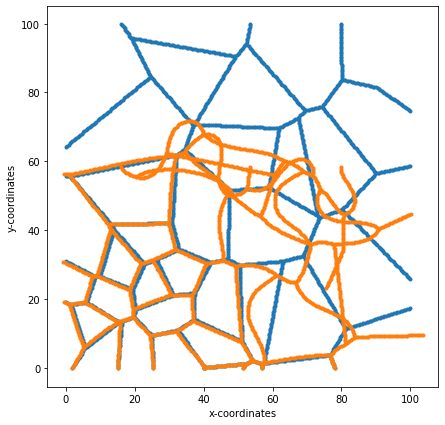

In [11]:
x_nodal_coord = dof_coords[x_dofs][:,0]
y_nodal_coord = dof_coords[y_dofs][:,1]
# Get nodal values 

# Plot displacement field
disp_x = x_nodal_coord + disp[-1][x_dofs]
disp_y = y_nodal_coord + disp[-1][y_dofs]

plt.figure(figsize=(7,7))
plt.scatter(x_nodal_coord,y_nodal_coord, marker = '.')
plt.scatter(disp_x, disp_y, marker = '.')

plt.xlabel('x-coordinates')
plt.ylabel('y-coordinates')
plt.axis('equal')
plt.show()

Text(0.5, 1.0, 'Equilibrium path')

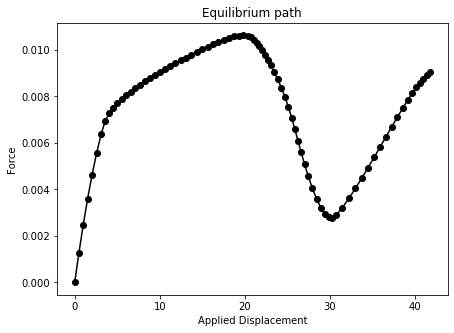

In [12]:
plt.figure(figsize=(7,5))
plt.plot(lmbda, f_reac, c='k', marker = 'o')
plt.xlabel('Applied Displacement')
plt.ylabel('Force')
plt.title('Equilibrium path')

## Optional: Creating an animation from solution snapshots

In [16]:
from matplotlib import animation, rc

plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

ax.set_xlim([0,100])
ax.set_ylim([0,100])

deformed, = ax.plot([], [], lw = 7, c = 'r', label = 'Deformed Configuration', ls = 'None', marker = '.')
init, = ax.plot(x_nodal_coord, y_nodal_coord, c='k', lw = 5, ls = 'None', label = 'Initial Configuration', marker = '.', alpha = 0.3)
ax.legend(loc = 'lower right')

def drawframe(n):
    disp_x = x_nodal_coord + disp[n][x_dofs]
    disp_y = y_nodal_coord + disp[n][y_dofs]
    
    deformed.set_data(disp_x,disp_y)
    return deformed,

plt.close()
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(lmbda), interval=40, blit=True)

anim